# ATP and kinase conformations

This notebook analyses kinase conformations associated with ATP binding. The main goal is to identify relevant conformations for ATP binding and how Mg2+ ions are involved. This can later be used to reliably generate wildtype ATP/Mg2+ bound kinase conformations, which can be employed to predict the impact of point mutations on ATP affinity.

## Content

- Retrieve relevant kinase structures  
- Analyze conformations
- Analyze Mg2+ ions

In [1]:
from pathlib import Path

import klifs_utils
import MDAnalysis as mda

## 1. Retrieve relevant kinase structures

Kinase structures will be retrieved from the [KLIFS database](https://klifs.vu-compmedchem.nl/) and filtered to find the most relevant structures.

In [2]:
# retrieve kinase structures
kinase_ids = klifs_utils.remote.kinases.kinase_names().kinase_ID.to_list()
kinase_df = klifs_utils.remote.structures.structures_from_kinase_ids(kinase_ids)
print('Number of PDB entries:', len(set(kinase_df['pdb'])))
print('Number of KLIFS entries:', len(kinase_df))
kinase_df.tail()

Number of PDB entries: 5342
Number of KLIFS entries: 11633


,structure_ID,kinase,species,kinase_ID,pdb,alt,chain,rmsd1,rmsd2,pocket,...,bp_I_A,bp_I_B,bp_II_in,bp_II_A_in,bp_II_B_in,bp_II_out,bp_II_B,bp_III,bp_IV,bp_V
11628,9098,PI4K2B,Human,1091,4wtv,B,A,1.554,3.088,ERISQGSSGSYFVGVFKPKGYLSEAGAYLVDNSIVPKTKVVGSFQL...,...,False,False,False,False,False,False,False,False,False,False
11629,9095,PI4K2B,Human,1091,4wtv,A,A,1.554,3.088,ERISQGSSGSYFVGVFKPKGYLSEAGAYLVDNSIVPKTKVVGSFQL...,...,False,False,False,False,False,False,False,False,False,False
11630,9096,PI4K2B,Human,1091,4wtv,B,B,1.554,3.041,ERIS___SGSYFVGVFKPKGYLSEAGAYLVDNSIVPKTKVVGSFQL...,...,False,False,False,False,False,False,False,False,False,False
11631,9070,PI4KA,Human,1096,6bq1,,A,1.704,2.676,_PMQSAAKAPYLAAIFKVGDCRQDMLALQIIDLFVFPYRVVCGVIE...,...,False,True,False,False,False,False,False,False,False,False
11632,9069,PI4KA,Human,1096,6bq1,,E,1.699,2.670,_PMQSAAKAPYLAAIFKVGDCRQDMLALQIIDLFVFPYRVVCGVIE...,...,True,True,False,False,False,False,False,False,False,False


Since the focus is on ATP binding, entries will be scanned for ATP in the orthosteric pocket. Also, entries will be removed that have more than one ligand in the orthosteric pocket or have an additional allosteric binder. This ensures a clean "unbiased" ATP binding mode.

In [3]:
# filter for entries with ATP in the binding pocket
kinase_df = kinase_df[kinase_df["ligand"] == "ATP"]
print('Number of PDB entries:', len(set(kinase_df['pdb'])))
print('Number of KLIFS entries:', len(kinase_df))

Number of PDB entries: 109
Number of KLIFS entries: 212


In [4]:
# filter for entries with a single orthosteric ligand
kinase_df = kinase_df.groupby('pdb').filter(lambda x: len(set(x['ligand'])) == 1)
print('Number of PDB entries:', len(set(kinase_df['pdb'])))
print('Number of KLIFS entries:', len(kinase_df))

Number of PDB entries: 109
Number of KLIFS entries: 212


In [5]:
# filter for entries that do not contain an allosteric ligand, since this might affect the conformation
kinase_df = kinase_df[kinase_df["allosteric_ligand"] == 0]
print('Number of PDB entries:', len(set(kinase_df['pdb'])))
print('Number of KLIFS entries:', len(kinase_df))

Number of PDB entries: 80
Number of KLIFS entries: 151


To reduce noise, the entries will be further filtered to retrieve 1 entry per PDB identifier. KLIFS reports a quality score, which is used to pick the "best" quality chain and alternate location for further analysis.

In [6]:
# sort by alt, chain and quality score to pick representative structure in next step
kinase_df = kinase_df.sort_values(by=['quality_score', 'resolution', 'alt','chain'],ascending=[False, True, True, True])
# keep entry with highest quality score
kinase_df = kinase_df.groupby('pdb').head(1)
print('Number of PDB entries:', len(set(kinase_df['pdb'])))
print('Number of KLIFS entries:', len(kinase_df))

Number of PDB entries: 80
Number of KLIFS entries: 80


## 2. Analyze conformations

It would be interesting to identify the conformations that kinases prefere to bind ATP. Let's find all DFG and $\alpha$C helix conformations deposited in KLIFS for the filtered entries. Once available in KinoML this analysis can be carried out with the Dunbrack classification.

<AxesSubplot:>

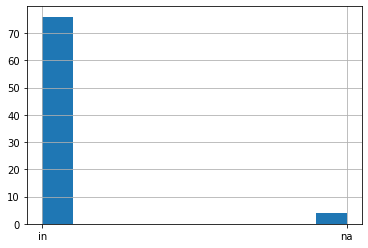

In [7]:
kinase_df.DFG.hist()

In [8]:
kinase_df[kinase_df.DFG == 'na']['pdb']

6436     3gni
10102    3rep
10104    3kmw
698      4fg8
Name: pdb, dtype: object

Not surprisingly, most kinases show a DFG in conformation, which positions the Asp of the DFG motif in the binding site. This is important, since the DFG Asp complexes Mg2+ to bind the ATP's phosphate groups ([Modi 2018](https://doi.org/10.1073/pnas.1814279116)). The entries reptorting a `'na'` DFG conformation have either missing residues in the DFG motif or are special kinases that do not contain the DFG motif. We will delete those for now from further analysis. However, those entries might be interesting later to analyze the effect of very central loss of function mutations in the DFG motif.

In [9]:
kinase_df = kinase_df[kinase_df.DFG != 'na']

Next the $\alpha$C helix conformations.

<AxesSubplot:>

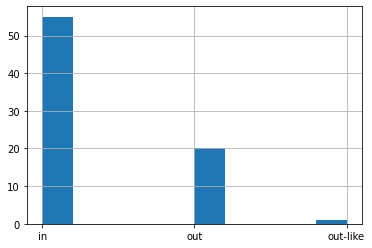

In [10]:
kinase_df.aC_helix.hist()

According to the published literature, active kinase conformations, i.e., bound to ATP, should show an $\alpha$C helix in conformation [Modi 2018](https://doi.org/10.1073/pnas.1814279116). Surprisingly, ~30 % of pdb entries show an $\alpha$C helix out or out-like conformation.

In [11]:
print(list(kinase_df[kinase_df.aC_helix != "in"].pdb))

['2y4i', '4fvq', '3dkc', '5i4n', '1hck', '1b38', '4fvr', '3vvh', '1b39', '4an3', '3dv3', '1s9j', '3e8n', '3eqb', '3dy7', '3pp1', '3os3', '1ua2', '5d9h', '1s9i', '4fg9']


The untypical $\alpha$C helix conformation can be explained by ***several mutations*** (4fvq, 4fvr, 5i4n), ***dependency on other interaction partners*** (cyclin - 1b39, 1b38, 1ua2, 1hck, Ca2+/calmodulin - 4fg9) or ***additional ligands*** that were not reported by KLIFS (4an3, 3os3, 3dy7, 1s9j, 3e8n, 1s9i, 3pp1, 3vvh, 3dv3, 3eqb). For some entries it is less clear (STK39 - 5d9h, MAP2K1 - 2y4i, c-MET - 3dkc).

## 3. Analyze Mg2+ ions

Let's focus on the kinases with the active conformation (DFG in, $\alpha$C helix in). Split the dataset according to the number of co-crystalized Mg2+ ions.

In [12]:
# retrieve prealigned complexes from KLIFS for visualization in e.g. PyMol
directory = Path("~/data/kinases/atp").expanduser()
directory.mkdir(parents=True, exist_ok=True)

for index, row in kinase_df[kinase_df.aC_helix == "in"].iterrows():
    pdb_text = klifs_utils.remote.coordinates.complex._complex_pdb_text(row['structure_ID'])
    path = directory / f"{row['pdb']}.pdb"
    with open(path, 'w') as wf:
        wf.write(pdb_text)

In [13]:
# save structures in different folders according to number of co-crystalized Mg2+ ions
directory_no_mg = Path("~/data/kinases/atp/no_mg").expanduser()
directory_no_mg.mkdir(parents=True, exist_ok=True)
directory_one_mg = Path("~/data/kinases/atp/one_mg").expanduser()
directory_one_mg.mkdir(parents=True, exist_ok=True)
directory_two_mg = Path("~/data/kinases/atp/two_mg").expanduser()
directory_two_mg.mkdir(parents=True, exist_ok=True)
directory_more_mg = Path("~/data/kinases/atp/more_mg").expanduser()
directory_more_mg.mkdir(parents=True, exist_ok=True)

no_mg = []
one_mg = []
two_mg = []
more_mg = []
for index, row in kinase_df[kinase_df.aC_helix == "in"].iterrows():
    path = directory / f"{row['pdb']}.pdb"
    u = mda.Universe(path)
    num_mg = len(u.select_atoms("resname MG"))
    if num_mg == 0:
        no_mg.append(row["pdb"])
        path = directory_no_mg / f"{row['pdb']}.pdb"
    elif num_mg == 1:
        one_mg.append(row["pdb"])
        path = directory_one_mg / f"{row['pdb']}.pdb"
    elif num_mg == 2:
        two_mg.append(row['pdb'])
        path = directory_two_mg / f"{row['pdb']}.pdb"
    else:
        more_mg.append(row['pdb'])
        path = directory_more_mg / f"{row['pdb']}.pdb"
    pdb_text = klifs_utils.remote.coordinates.complex._complex_pdb_text(row['structure_ID'])
    with open(path, 'w') as wf:
            wf.write(pdb_text)

/home/david/miniconda3/envs/kinoml/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: MN
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [14]:
print(f"{len(no_mg)} structures without Mg2+: {no_mg}")
print(f"{len(one_mg)} structures with one Mg2+: {one_mg}")
print(f"{len(two_mg)} structures with two Mg2+: {two_mg}")
print(f"{len(more_mg)} structures more than two Mg2+: {more_mg}")

23 structures without Mg2+: ['3hrc', '3fjq', '5lvp', '4wtv', '5cu6', '4rrv', '2cch', '4wb7', '2biy', '4xw5', '3a7h', '1h1w', '3a8w', '4btj', '2ijm', '1atp', '1fin', '2yaa', '1jst', '4fg7', '3hmn', '4wae', '1ol6']
15 structures with one Mg2+: ['4eoj', '4dh1', '4eoo', '4eom', '5drd', '4eoq', '1qmz', '2cjm', '5dt3', '1gy3', '2cci', '3blq', '1fq1', '5wni', '3bu5']
17 structures with two Mg2+: ['1rdq', '3qam', '6no7', '3qal', '4din', '4wb8', '4wb5', '3x2w', '3x2v', '5dnr', '3q53', '4wb6', '4dh3', '4x6r', '3x2u', '4xbr', '6byr']
0 structures more than two Mg2+: []


Only 17 entries were found with the active DFG in/$\alpha$C helix in conformation and exactly two bound Mg2+ ions.